<a href="https://colab.research.google.com/github/NikuDubenco/DS-Unit-2-Classification-2/blob/master/Nicolae_Dubenco_class_imbalance_roc_auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Leading club review

In [18]:
!pip install category_encoders

In [0]:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [0]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# stratified sample, 10% of expired LC loans, grades A-D
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# current loans available for manual investing, June 17, 2019
current = pd.read_csv(current_location)

In [21]:
# calculate % of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# see % paid for charged off vs fully paid loans
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


## begin with baseline: expected value of random decisions

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

In [0]:
def simulate(n=10000, grades=['A', 'B', 'C', 'D'],
            start_date='2007-07-01',
            end_date='2019-03-01'):
  
  condition = ((history['grade'].isin(grades)) &
              (history['issue_d'] >= start_date) &
              (history['issue_d'] <= end_date))
  possible = history[condition]
  
  simulations = []
  for _ in tnrange(n):
    picks = possible.sample(40).copy()
    picks['paid'] = 25 * picks['percent_paid']
    paid = picks['paid'].sum()
    simulations.append(paid)
    
  simulations = pd.Series(simulations)
  sns.distplot(simulations)
  plt.axvline(x=1000)
  percent = percentileofscore(simulations, 1000)
  plt.title(f'{percent}% of simulations did not profit. {start_date}-{end_date}, {grades}')

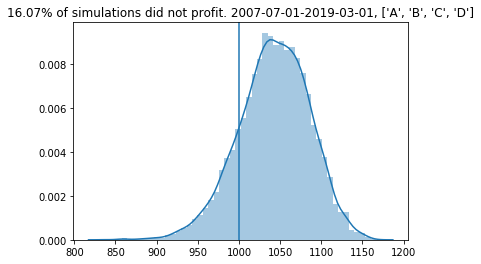

In [24]:
simulate()

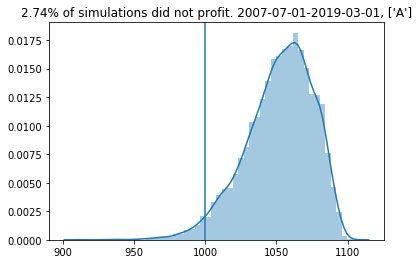

In [25]:
simulate(grades=['A'])

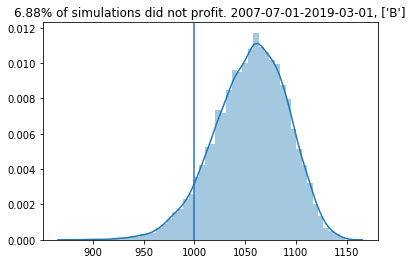

In [26]:
simulate(grades=['B'])

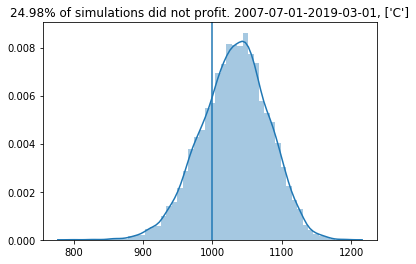

In [27]:
simulate(grades=['C'])

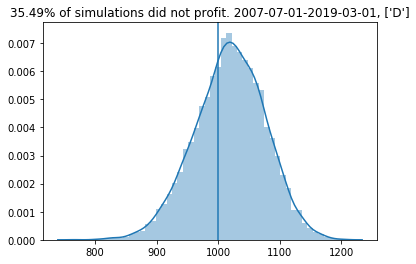

In [28]:
simulate(grades=['D'])

### Remove features to avoid leakage

In [0]:
# transform earliest_cr_line to an integer:
# how many days the earliest credit line was open, before the loan was issued.
# for current loans available for manual investing, assume the loan will be issued today.

history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

In [30]:
# use python sets to compare the historical columns & current columns

common_columns = set(history.columns) & set(current.columns)
common_columns

{'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'loan_amnt',
 'max_bal_bc',
 'member_id',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_s

In [31]:
just_history = set(history.columns) - set(current.columns)
just_history

{'collection_recovery_fee',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'funded_amnt_inv',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'issue_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'loan_status',
 'next_pymnt_d',
 'orig_projected_additional_accrued_interest',
 'out_prncp',
 'out_prncp_inv',
 'payment_plan_start_date',
 'percent_paid',
 'policy_code',
 'pymnt_plan',
 'recoveries',
 'settlement_amount',
 'settlement_date',
 'settlement_percentage',
 'settlement_status',
 'settlement_term',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp',
 'verification_status',
 'verification_status_joint'}

In [32]:
just_current = set(current.columns) - set(history.columns)
just_current

{'accept_d',
 'credit_pull_d',
 'disbursement_method',
 'effective_int_rate',
 'exp_d',
 'exp_default_rate',
 'housing_payment',
 'ils_exp_d',
 'is_inc_v',
 'list_d',
 'msa',
 'mtg_payment',
 'review_status',
 'review_status_d',
 'service_fee_rate',
 'verified_status_joint'}